<a href="https://colab.research.google.com/github/jcval94/ML-with-Python/blob/master/ML_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center><font size=6> ML DEMO José Carlos Del Valle López </font></h1>

#Introducción

<h1>Clase 0</h1>
<h2>¿Cómo resolver un problema de Ciencia de Datos?</h2>
<h3>¡La más cordial bienvenida!</h3>

<p>
En esta clase aprenderán a:
afrontar un problema de ciencia de datos

*   Manipulación de datos
*   Análisis exploratorio de datos (EDA)
*   Ingeniería de variables (feature engeineering)
*   Algoritmos supervisados y no supervisados 

con las Best Practices. Utilizando las librerías más utilizadas de  Python
</p>

#Librerías

El primer paso para afrontar un problema de ciencia de datos es "abrir nuestra caja de herramientas", en otras palabras, importar todas las funciones que consideremos necesarias para resolver el problema

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://miro.medium.com/max/840/1*XSrsoEr05s2epxOnezLmog.gif" width=300, align="center"></a>



In [ ]:
# Librerías para manipulación de datos
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

# Librerías para algoritmos supervisados y no supervisados
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Funciones útiles que facilitan la maniúlación de datos
from scipy import stats
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import zipfile
import glob
import traceback
import re
from datetime import datetime, timedelta

In [ ]:
#Funciones para conectarse a Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
import gspread_dataframe as gd

## Funciones útiles

En algunos casos, no existen librerías o funciones que nos ayuden a realizar algunos análisis, sin embargo, podemos escribirlas para su uso posterior

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://static.wikia.nocookie.net/dark-souls/images/d/dd/Herrero_Andre.jpg/revision/latest/top-crop/width/360/height/450?cb=20160903194839&path-prefix=es" width=140, align="center"></a>



In [ ]:
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)



def Evaluate_Responses(clase = 0, ejercicio = 0):
  cuaderno = 'https://docs.google.com/spreadsheets/d/1caMN10izIN2D5wF-QcEeDVgBKBoCwUu7KE6LgI1yugs/edit?usp=sharing'

  
  Estudiantes = ["Leslie", "Ariel", "Mauricio", "Victor", "N_1", "Omar"]

  ws = gc.open('Clase 0 - Ejercicios')

  print('Calificando...')
  time.sleep(1)
  for estudiante in Estudiantes:
    existing_ = gd.get_as_dataframe(ws.worksheet(estudiante))
    existing = existing_.copy()


    existing = existing[[col for col in existing.columns if 'Unnamed:' not in col]][~np.isnan(existing.Clase)]
    clase_hoy = existing[(existing['Ejercicio']==(ejercicio))&(existing['Clase']==(clase))]
    # print(clase_hoy.shape)
    r_list = ['from pandas import Series', 'pd.Series()', 'Leer el archivo', "Cierto"]
    Resp = pd.DataFrame({'N. Pregunta':list(range(1,31)),'Respuesta_ok':r_list+['']*(30-len(r_list))}, index=range(30))
    clase_hoy = clase_hoy.merge(Resp, on='N. Pregunta')
    clase_hoy['Stars'] = ["***" if x == y else '**' if x==y.lower().replace('()','') else '*' for x, y in clase_hoy[['Respuesta','Respuesta_ok']].values]
    clase_hoy['Puntos'] = ["10" if x == y else '6' if x==y.lower().replace('()','') else '3' for x, y in clase_hoy[['Respuesta','Respuesta_ok']].values]
    clase_hoy = clase_hoy.drop(columns='Respuesta_ok')
    # print(clase_hoy)
    existing_.update(clase_hoy)

    gd.set_with_dataframe(ws.worksheet(estudiante), existing_)

  print('Oh, muy buen trabajo :)')
  time.sleep(3)
  print('Muy bonita letra estudiante número '+ str(int(random.random()*len(Estudiantes))))
  time.sleep(2)
  print('Buen trabajo, el algoritmo está orgulloso de ustedes!!!')

Ejercicio 1:

¿Qué debo escribir si quiero importar solamente la función *Series* desde la librería pandas?

Si la librería pandas ya ha sido importada, ¿Cómo llamaría a la función *Series*?

Doble click __aqui__ para ver la solución.

<!-- Código ganador:

from pandas import Series

pd.Series()

-->

In [ ]:
Evaluate_Responses(ejercicio = 1)

Calificando...
Oh, muy buen trabajo :)
Muy bonita letra estudiante número 1
Buen trabajo, el algoritmo está orgulloso de ustedes!!!


#Lectura de datos

Una vez importadas la herramientas necesarias para ejecutar el código, es necesario leer la información.

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://pbs.twimg.com/media/CiuVN84WkAAafFT.jpg" width=240, align="center"></a>

Existen dos motivos por los que leo la informaión desde la carpeta:


*   Trato de no comprometer la integridad de la computadora en caso de tener información maliciosa
*   En caso de que la información esté distribuida en muchos archivos o ésta se disponibilice información diaria, semanal, mensual, etc. Es mucho más sencillo de productivizar



In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Así como las casas tienen una dirección, los documentos también, y resulta mucho más seguro preguntar cuál es la dirección de un documento en lugar de descargarlo y resubirlo al entorno de Google Colab.

Ventajas:

*   Si el contenido cambia, todo estará completamente actualizado


<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://www8.garmin.com/manuals/webhelp/drive40-50-60/Shared/GUID-3721E903-741E-4FC0-ACEE-CA0DBAE84ADF-high.jpg" width=140, align="center"></a>

*   Para archivos grandes o que parezcan inseguros la máquina no corre peligro

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://www.segurilatam.com/wp-content/uploads/sites/5/2021/04/troyano-virus-900x600.jpg" width=140, align="center"></a>

*   Lectura múltiple

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://static.tvtropes.org/pmwiki/pub/images/super_speed_reading.jpg" width=140, align="center"></a>




In [ ]:
url = 'https://drive.google.com/file/d/1e7xgUVzLwUuqUlapCnU-yFwd-pMI_eBK/view'
id_ = url.split('/')[-2]

# Toco la puerta para ver si hay alguien
links = drive.CreateFile({'id':id_})

# Si hay alguien (un zip) lo descomprimo para ver su interior
links.GetContentFile('folder.zip',mimetype=links['mimeType'])
with zipfile.ZipFile('folder.zip',"r") as zip_ref:
  zip_ref.extractall()

In [ ]:
# Leo de uno por uno todo el contenido del zip
docs = {}
for archivo in zip_ref.namelist():
  nombre_ar = archivo.split('/')[1].split('.')[0]
  docs[nombre_ar] = pd.read_csv(archivo)

In [ ]:
# entrenamiento y validación
# docs['v'].head(), docs['e'].head()

Ejercicio 2:

En el ejemplo anterior, ¿Qué objetivo tiene la función pd.read_csv? 

*Leer el archivo, *Descargar el archivo, *Borrar el archivo

Doble click __aqui__ para ver la solución.

<!-- Código ganador:

Leer el archivo

-->

In [ ]:
# Evaluate_Responses(ejercicio = 2)

#Limpieza y calidad de datos

Ya que se tiene la inforamción disponible, ahora hay que limpiarla

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://www.finereport.com/en/wp-content/uploads/2019/12/01.jpg" width=340, align="center"></a>


En esta sección se garantiza que los datos existentes y aquellos nuevos que se extraigan cumplan con reglas de negocio previamente señaladas o en este caso, que la información tenga los formatos correspondientes

In [ ]:
col_validas_e = [col for col in docs['e'].columns if "Unnamed:" not in col]
col_validas_v = [col for col in docs['v'].columns if "Unnamed:" not in col]

No utilizo drop dado que puede haber situaciones en donde sea más de una columna

In [ ]:
docs['e'] = docs['e'][col_validas_e]
docs['v'] = docs['v'][col_validas_v]

Revisó que los formatos sean correctos y cambio el de aquellas columnas que puedan ser transformadad

In [ ]:
docs['e'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249556 entries, 0 to 249555
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   device_mac      249556 non-null  object
 1   branch_office   249556 non-null  int64 
 2   month_tz        249556 non-null  int64 
 3   day_tz          249556 non-null  int64 
 4   day_of_week_tz  249556 non-null  object
 5   hour_tz         249556 non-null  int64 
 6   visitor         249556 non-null  bool  
 7   tiempodeses     249556 non-null  int64 
dtypes: bool(1), int64(5), object(2)
memory usage: 13.6+ MB


In [ ]:
docs['e'].loc[:,'day_of_week_tz'] = docs['e']['day_of_week_tz'].apply(lambda x: time.strptime(x.lower(), "%A").tm_wday)
docs['e'].loc[:,'visitor'] = docs['e']['visitor'].apply(lambda x: int(x))

In [ ]:
docs['v'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   device_mac      90000 non-null  object
 1   branch_office   90000 non-null  int64 
 2   month_tz        90000 non-null  int64 
 3   day_tz          90000 non-null  int64 
 4   day_of_week_tz  90000 non-null  object
 5   hour_tz         90000 non-null  int64 
 6   tiempodeses     90000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 4.8+ MB


In [ ]:
docs['v'].loc[:,'day_of_week_tz'] = docs['v']['day_of_week_tz'].apply(lambda x: time.strptime(x.lower(), "%A").tm_wday)

No hay valores nulos por lo que no es necesario imputar datos ni eliminar columnas y dado que no se tiene la información de los minutos, asumo que los valores repetidos representan dos inicios de sesión que duraron el mismo tiempo en la misma hora

Las variables categóricas ya han sido debidamente transforamdas, no hay necesidad de hacer one hot encoding u otra técnica de discretización

Ejercicio 3:

¿Por medio del atributo ".info()" se puede determinar si hay que inputar datos? 

*Cierto, *Falso

Doble click __aqui__ para ver la solución.

<!-- Código ganador:

Cierto

-->

In [ ]:
# Evaluate_Responses(ejercicio = 3)

# Feature Engeineering y Análisis exploratorio de datos (EDA)

El siguiente paso es sumergirnos en los datos, agregar nuevas variables y ver el comportamiento de los mismos

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://cdn.themedizine.com/2019/06/1EDE9492-9029-4088-B6B3-F9E410183196-1000x538.jpeg" width=340, align="center"></a>




Distribución de los visitantes

Tomo una muestra del 25% para visualizar los plots y me aseguro que las distribuciones en ambos conjuntos de datos coincidan

In [ ]:
muestra_s1 = int(docs['e'].shape[0]/4)
muestra_s2 = int(docs['v'].shape[0]/4)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


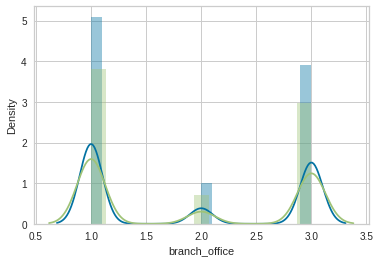

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


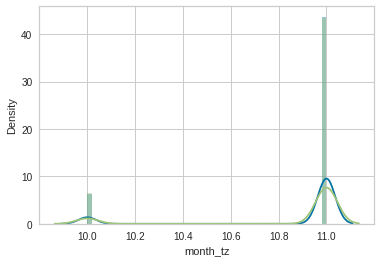

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


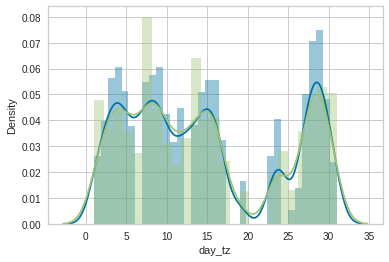

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


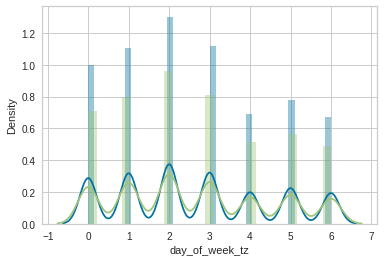

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


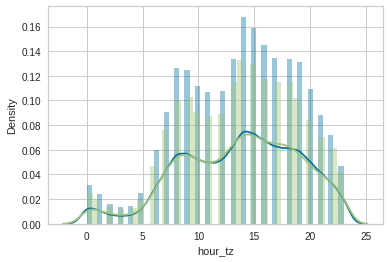

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


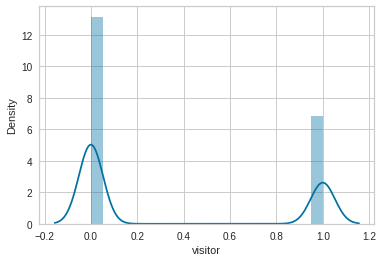

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


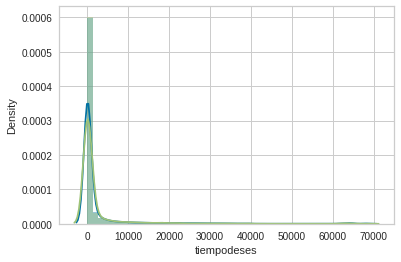

In [ ]:
var_cont = [c for c in docs['e'].columns if c not in 'device_mac']

for col in var_cont:
  muestra = docs['e'][col].sample(muestra_s1)
  sns.distplot(muestra)
  if col == 'visitor':
    plt.show()
    continue
  muestra_v = docs['v'][col].sample(muestra_s2)
  sns.distplot(muestra_v)
  plt.show()

Ahora nos toca indagar en los datos observados

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://sm.ign.com/ign_es/screenshot/default/maxresdefault_tdsu.jpg" width=340, align="center"></a>


*   Reviso que no haya un desbalance en la cantidad de 0's y 1's, de haberlo podría necesario hacer bagging u oversampling

*   Reviso si la inforamción temporal corresponde a distintos periodos de tiempo

*   Veo que hay una caida de casos los últimos






Agregar información que podría ser relevante temporal (inicios en temporalidades anteriores)

## Feature Eneineering

Dada la ventana temporal que se tiene y que la información del entrenamiento, voy a decidir separar en análisis en dos secciones:

*   Sin información previa (1 semana)
*   Con información previa (después de la primera semana)

El motivo del porqué se hace esto, es debido a que tener información de hasta 7 días puede aportar una mejora significativa para las variables que cumplen con esta característica

Después de observar las distribuciones, se agregarán variables que puedan identificar los picos y valles en la distribución para el set de entrenamiento y validación

In [ ]:
for set_ in ['e','v']:
  docs[set_].loc[:,'date'] = pd.to_datetime('2021-' + docs[set_]['month_tz'].astype(str)+'-'+docs[set_]['day_tz'].astype(str))
  docs[set_].loc[:,'ayer'] = docs[set_]['date'].apply(lambda x: x-timedelta(days=1))
  docs[set_].loc[:,'antier'] = docs[set_]['date'].apply(lambda x: x-timedelta(days=2))
  docs[set_].loc[:,'hace7dias'] = docs[set_]['date'].apply(lambda x: x-timedelta(days=7))
  docs[set_].loc[:,'madrugada'] = docs[set_]['hour_tz'].apply(lambda x: int(x<7))
  docs[set_].loc[:,'ult_dias_semana'] = docs[set_]['day_of_week_tz'].apply(lambda x: int(x>=4))
  docs[set_].loc[:,'dias_mes1'] = docs[set_]['day_tz'].apply(lambda x: int(x>=17)+int(x<=23))

  docs[set_].loc[:,'semana_anio'] = docs[set_]['date'].apply(lambda x: x.weekofyear)
  docs[set_].loc[:,'semana_pasada'] = docs[set_]['semana_anio'].apply(lambda x: x-1)

Veamos si hace sentido agregar información de inicios de sesión anteriores

In [ ]:
docs['e'][['device_mac','date']].value_counts()

device_mac         date      
00:23:68:b2:58:a7  2021-11-03    22
8c:0c:90:12:dd:68  2021-11-02    22
78:ac:c0:8c:38:46  2021-10-27    22
                   2021-11-14    22
00:20:00:94:8e:d3  2021-11-05    22
                                 ..
94:b1:0a:bb:ed:e6  2021-11-14     1
94:b1:0a:bb:ed:c8  2021-11-27     1
94:b1:0a:bb:ed:64  2021-11-09     1
94:b1:0a:bb:eb:88  2021-11-09     1
84:38:38:17:3a:0c  2021-10-28     1
Length: 187273, dtype: int64

Dado que hay casos como 78:ac:c0:8c:38:46 que tienen más de una fecha, es posible que esto sea un indicador de importancia

Agregar información de acuerdo al dispositivo

In [ ]:
for set_ in ['e','v']:
  docs[set_]['name_len'] = docs[set_]['device_mac'].apply(lambda x: len(x))

Número de inicios de sesión diaria en horas distintas, esta información se utilizará para hacer merge sobre días anteriores, pues no tendría sentido conocer la inforamción del día si no estamos seguros si este ha terminado o no (dada la naturaleza de los datos)

In [ ]:
for set_ in ['e','v']:
  for tiempos in ['ayer', 'antier', 'hace7dias', 'semana_pasada']:
    print(tiempos)
    # Agrego con distintos estadísticos
    e_agg = pd.pivot_table(docs[set_], 
                          index = ['device_mac',tiempos],
                          aggfunc=[len,'sum','mean','max','min'], values = ['tiempodeses']).reset_index()
    
    # Cambio la estructura de las columnas para que no haya errores al entrenar el modelo
    e_agg.columns = [col[0]+'_'+col[1]+'_'+tiempos if len(col)==2 else col for col in e_agg.columns]

    # Agrego las nuevas columnas de los inicios de sesión anteriores, coloco un left join en caso de que el usuario
    # no haya tenido actividad la semana pasada 
    if tiempos=='semana_pasada':
      tiemo_key = 'semana_anio'
    else:
      tiemo_key = 'date'
    
    docs[set_] = docs[set_].merge(e_agg, left_on = ['device_mac',tiemo_key], right_on=['device_mac__'+tiempos,tiempos+'__'+tiempos], how='left')
    

ayer
antier
hace7dias
semana_pasada
ayer
antier
hace7dias
semana_pasada


Elimino las llaves

In [ ]:
for set_ in ['e','v']:
  docs[set_].drop(columns=['ayer','antier','hace7dias'], inplace=True)
  docs[set_] = docs[set_][[col for col in docs[set_].columns if '__' not in col or col not in ['ayer','antier','hace7dias']]]

In [ ]:
docs[set_]

,device_mac,branch_office,month_tz,day_tz,day_of_week_tz,hour_tz,tiempodeses,date,madrugada,ult_dias_semana,dias_mes1,semana_anio,semana_pasada,name_len,device_mac__ayer,ayer__ayer,len_tiempodeses_ayer,sum_tiempodeses_ayer,mean_tiempodeses_ayer,max_tiempodeses_ayer,min_tiempodeses_ayer,device_mac__antier,antier__antier,len_tiempodeses_antier,sum_tiempodeses_antier,mean_tiempodeses_antier,max_tiempodeses_antier,min_tiempodeses_antier,device_mac__hace7dias,hace7dias__hace7dias,len_tiempodeses_hace7dias,sum_tiempodeses_hace7dias,mean_tiempodeses_hace7dias,max_tiempodeses_hace7dias,min_tiempodeses_hace7dias,device_mac__semana_pasada,semana_pasada__semana_pasada,len_tiempodeses_semana_pasada,sum_tiempodeses_semana_pasada,mean_tiempodeses_semana_pasada,max_tiempodeses_semana_pasada,min_tiempodeses_semana_pasada
0,a8:81:95:56:31:3c,1,11,17,3,4,0,2021-11-17,1,0,2,46,45,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44:6e:e5:1b:68:81,3,11,3,3,22,477,2021-11-03,0,0,1,44,43,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,44:6e:e5:1b:68:81,2021-11-03,1.0,3.0,3.0,3.0,3.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0c:b3:19:10:78:17,3,11,12,5,10,0,2021-11-12,0,1,1,45,44,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44:74:6c:0a:20:23,3,11,27,6,21,0,2021-11-27,0,1,1,47,46,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ac:5f:3e:c8:dc:35,1,11,27,6,16,0,2021-11-27,0,1,1,47,46,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,44:74:6c:cc:85:28,1,11,29,1,18,530,2021-11-29,0,0,1,48,47,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89996,a0:91:69:e3:58:ba,3,11,28,0,7,0,2021-11-28,0,0,1,47,46,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89997,64:51:06:9c:7b:57,3,11,5,5,9,0,2021-11-05,0,1,1,44,43,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,64:51:06:9c:7b:57,44.0,2.0,0.0,0.0,0.0,0.0
89998,f8:cf:c5:d9:10:79,3,11,4,4,9,0,2021-11-04,0,1,1,44,43,17,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## División de los modelos

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://i0.wp.com/hipertextual.com/wp-content/uploads/2015/10/regreso-al-futuro-wallpaper.jpg?resize=1200%2C900&ssl=1" width=340, align="center"></a>



*   Con información anterior

*   Sin información anterior



In [ ]:
min_date_7 = min(docs['e']['date'])+timedelta(days=7)
min_date_7_2 = min(docs['v']['date'])+timedelta(days=7)

# Los NA's en este caso significa que no hay registros anteriores, por lo que 
# No se toman en cuenta las nuevas columnas
docs['e_sin_i'] = docs['e'][docs['e']['date']<min_date_7][col_validas_e+['date']]
# Los NA's en este caso significa que no hubo actividad en días anteriores
docs['e_con_i'] = docs['e'][docs['e']['date']>=min_date_7].fillna(0)
# ------------------
docs['v_sin_i'] = docs['v'][docs['v']['date']<min_date_7_2][col_validas_v+['date']]
# Los NA's en este caso significa que no hubo actividad en días anteriores
docs['v_con_i'] = docs['v'][docs['v']['date']>=min_date_7_2].fillna(0)

In [ ]:
# docs[datos_eval].sample(size_dv, random_state=324).drop(columns = ['device_mac','date'])

## Modelo No Supervisado

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://miro.medium.com/max/1400/1*lhkCOodCMZ0-SSziEDpwpA.png" width=390, align="center"></a>


Para finalizar el proceso de ingeniería de variables se hará un modelo no supervizado que posteriormente se aplicacrá al Set de Prueba

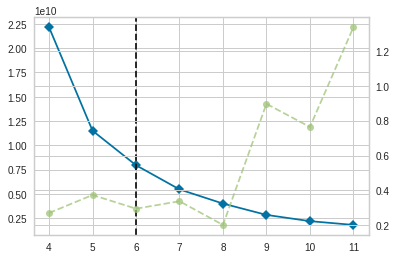

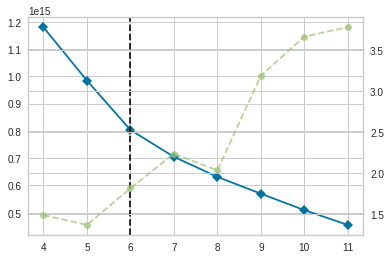

In [ ]:
# Utilizamos el método del codo para ver la separación más indicada sobre una muestra de los datos

for datos_eval in ['e_sin_i','e_con_i']:
  size_dv = int(docs[datos_eval].shape[0]/3)
  X = docs[datos_eval].sample(size_dv, random_state=324).drop(columns = ['device_mac','date', 'visitor'])
  
  col_cont = X.describe().columns
  X = X[col_cont]
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=(4,12))

  visualizer.fit(X)
  plt.show()

In [ ]:
modelos_no_sup = []
for  datos_eval, nclus in [('e_sin_i', 6),('e_con_i',6)]:
  X = docs[datos_eval].drop(columns = ['device_mac','date','visitor'])
  try:
    X = X.drop(columns = ['cluster'])
  except:
    print('Ya ha sido eliminado')

  col_cont = X.describe().columns
  X = X[col_cont]

  db = KMeans(init="k-means++", n_clusters=nclus, n_init=4, random_state=324).fit(X)
  modelos_no_sup.append(db)
  docs[datos_eval].loc[:,'cluster'] = db.labels_

Ya ha sido eliminado
Ya ha sido eliminado


Ejecutar los modelos no supervisados en el set te validación

In [ ]:
for km_mod, datos_eval in zip(modelos_no_sup, ['v_sin_i','v_con_i']):
  X1 = docs[datos_eval].drop(columns = ['device_mac','date'])
  col_cont = X1.describe().columns
  X1 = X1[col_cont]
  
  docs[datos_eval].loc[:,'cluster'] = km_mod.predict(X1)

In [ ]:
X1 = docs[datos_eval][['madrugada','tiempodeses','cluster']].sample(10000)

In [ ]:
# plt.scatter(X1['madrugada'], X1['tiempodeses'], c = X1['cluster'])

In [ ]:
# [c for c in X.columns if c not in X1.columns]

['visitor']

# Elección de mejores variables

<a href="https://www.linkedin.com/in/jose-carlos-del-valle/"><img src="https://i.pinimg.com/originals/d7/2f/40/d72f40b11a148ce40d538cde0a8c8898.gif" width=340, align="center"></a>

In [ ]:
va_obj = 'visitor'
modelo = 'e_sin_i'

In [ ]:
X = docs[modelo].drop(columns=[va_obj]+['device_mac','date'])
y = docs[modelo][va_obj]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=112)

Verificamos que sea la misma catidad de datos

In [ ]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_tests Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (19309, 7)
y_train Shape: (19309,)
X_tests Shape: (6437, 7)
y_test Shape: (6437,)


Realizo un grid search para evitar overfitting



In [ ]:
rf = RandomForestClassifier(random_state=np.random.RandomState(seed=3523))
param_grid = {'n_estimators':range(40,121,40),'max_depth':range(4,8,3)}
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1)

In [ ]:
%%time
cv.fit(X_train,y_train)

CPU times: user 1.23 s, sys: 101 ms, total: 1.34 s
Wall time: 13.2 s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7F23D3394AF0),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 8, 3),
                         'n_estimators': range(40, 121, 40)})

resultados preliminares

In [ ]:
y_pred = cv.best_estimator_.predict(X_test)
r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

0.7921200506574596

## variables importantes en general, lista con las variables ej: importancia > 0

Calculamos la importancia de las variables del modelo y los resultados los guardamos en la lista <b>importances</b>, después guardamos los nombres de las variables del modelo en la lista <b> feature_list</b>, finalmente en la lista <b>feature_importances</b> guardamos el nombre de las variables con su respectivo valor de importancia. 

In [ ]:
importances = list(cv.best_estimator_.feature_importances_)
feature_list=list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [ ]:
var_impr_gral = [pair[0] for pair in feature_importances if pair[1]>0.02]

In [ ]:
feature_importances

[('tiempodeses', 0.82),
 ('cluster', 0.17),
 ('hour_tz', 0.01),
 ('branch_office', 0.0),
 ('month_tz', 0.0),
 ('day_tz', 0.0),
 ('day_of_week_tz', 0.0)]

In [ ]:
IVs = pd.DataFrame(data = list(range(2))).transpose()
IVs.columns = ['VAR_NAME', 'IV']
IVs = IVs.iloc[:-1,]
Flags = [va_obj]
for flag in Flags:
  final_iv, IV = data_vars(X, y)
  IVs = pd.concat([IVs, IV])

IVs.sort_values(by='IV', ascending=False).head()

,VAR_NAME,IV
6,tiempodeses,6.816494
1,cluster,0.145216
2,day_of_week_tz,0.010506
3,day_tz,0.010506
4,hour_tz,0.005201


Hacemos un DataFrame <b>list_ivs_1</b> solo con las variables cuyo poder predictivo sea suficiente.

In [ ]:
ivs = IVs.sort_values(by='IV', ascending=False)
lis_ivs_1 = ivs[ivs.IV>.1]['VAR_NAME'].tolist()

## Listas de variables

Hacemos una lista <b>var_imp_R_</b> con todas las variables importantes que son las variable del information value <b>lis_ivs_1</b> y <b>var_impr_gral</b> variables con mayor importancia del entrenamiento del Random Forest.

In [ ]:
var_imp_R = list(set(lis_ivs_1+var_impr_gral))
len(var_imp_R)

2

# Pruebas

Aplicamos nuevamente el modelo Random Forest pero ahora con las mejores variables que se calcularon anteriormente <b>var_imp_R</b>

In [ ]:
X = docs[modelo][var_imp_R]
y = docs[modelo][va_obj]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=112)

Incremento el número de hiperparámetros y descarto variables que no tengan poder predictivo

In [ ]:
rf = RandomForestClassifier(random_state=np.random.RandomState(seed=34586))
param_grid = {'n_estimators':range(40,161,30),'max_depth':range(3,10,2)}
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7F23D3394D10),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'n_estimators': range(40, 161, 30)})

Calculamos el error del modelo ahora con las mejores variables y los mejores parámetros.

# Evaluación 

In [ ]:
predicciones = y_pred = cv.best_estimator_.predict(X_train)
predicciones = [round(x,0) for x in predicciones]
rmse = mean_squared_error(y_true  = y_train, y_pred  = predicciones, squared = False) 
print(f"El error (rmse) de traint es: {rmse}")

predicciones = y_pred = cv.best_estimator_.predict(X_test)
predicciones = [round(x,0) for x in predicciones]
rmse = mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de traint es: 0.2262031148978659
El error (rmse) de test es: 0.22676302526802958


Observamos la ROC del modelo sin información pasada

In [ ]:
roc_auc = roc_auc_score(y_test, predicciones)
roc_auc

0.9381699583931873

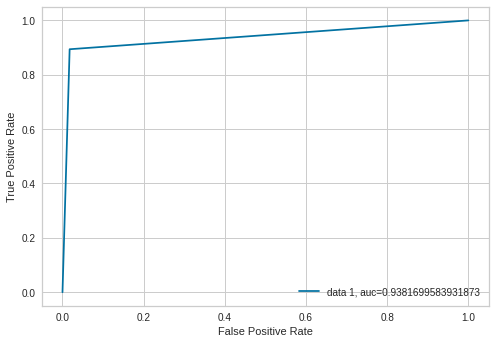

In [ ]:
# y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, predicciones)
auc = roc_auc_score(y_test, predicciones)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Resultados en el set de validación

Utilizo todos los datos del modelo con las mejores variables y los mejores parámetros para entrenar

In [ ]:
param_grid = cv.best_params_
param_grid = {'max_depth':[param_grid['max_depth']], 'n_estimators': [param_grid['n_estimators']]}

In [ ]:
rf = RandomForestClassifier(random_state=np.random.RandomState(seed=34586))
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7F23B553A270),
             n_jobs=-1, param_grid={'max_depth': [5], 'n_estimators': [40]})

In [ ]:
Validacion1 = cv.best_estimator_.predict(docs['v_sin_i'][var_imp_R])

In [ ]:
docs['v_sin_i']['predict'] = Validacion1

# Aplicamos el mismo procedimiento para el modelo con información

In [ ]:
modelo = 'e_con_i'

In [ ]:
X = docs[modelo].drop(columns=[va_obj]+['device_mac','date'])
col_cont = X.describe().columns
X = X[col_cont]
y = docs[modelo][va_obj]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=112)

In [ ]:
rf = RandomForestClassifier(random_state=np.random.RandomState(seed=3523))
param_grid = {'n_estimators':range(40,81,40),'max_depth':range(4,8,3)}
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1)

In [ ]:
%%time
cv.fit(X_train,y_train)

CPU times: user 7.88 s, sys: 144 ms, total: 8.03 s
Wall time: 1min 12s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7F23B553A9E0),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 8, 3),
                         'n_estimators': range(40, 81, 40)})

In [ ]:
y_pred = cv.best_estimator_.predict(X_test)
r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

0.8391917957265194

In [ ]:
importances = list(cv.best_estimator_.feature_importances_)
feature_list=list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
var_impr_gral = [pair[0] for pair in feature_importances if pair[1]>0.02]
feature_importances[:5]

[('tiempodeses', 0.6),
 ('sum_tiempodeses_semana_pasada', 0.07),
 ('max_tiempodeses_semana_pasada', 0.06),
 ('mean_tiempodeses_semana_pasada', 0.04),
 ('len_tiempodeses_ayer', 0.03)]

In [ ]:
IVs = pd.DataFrame(data = list(range(2))).transpose()
IVs.columns = ['VAR_NAME', 'IV']
IVs = IVs.iloc[:-1,]
Flags = [va_obj]
for flag in Flags:
  final_iv, IV = data_vars(X, y)
  IVs = pd.concat([IVs, IV])

IVs.sort_values(by='IV', ascending=False).head()

,VAR_NAME,IV
32,tiempodeses,7.458134
18,mean_tiempodeses_semana_pasada,0.708351
31,sum_tiempodeses_semana_pasada,0.707639
14,max_tiempodeses_semana_pasada,0.707639
9,len_tiempodeses_semana_pasada,0.624445


Como se esperaba, añadir información sobre inicios de sesión anteriores añade poder predictivo para aquellos registros que pueden disponer de esa información

In [ ]:
ivs = IVs.sort_values(by='IV', ascending=False)
lis_ivs_1 = ivs[ivs.IV>.1]['VAR_NAME'].tolist()

In [ ]:
var_imp_R = list(set(lis_ivs_1+var_impr_gral))
len(var_imp_R)

23

In [ ]:
X = docs[modelo][var_imp_R]
y = docs[modelo][va_obj]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=112)

In [ ]:
rf = RandomForestClassifier(random_state=np.random.RandomState(seed=34586))
param_grid = {'n_estimators':range(40,161,30),'max_depth':range(3,10,2)}
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7F23B553A5A0),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'n_estimators': range(40, 161, 30)})

In [ ]:
predicciones = y_pred = cv.best_estimator_.predict(X_train)
predicciones = [round(x,0) for x in predicciones]
rmse = mean_squared_error(y_true  = y_train, y_pred  = predicciones, squared = False) 
print(f"El error (rmse) de traint es: {rmse}")

predicciones = y_pred = cv.best_estimator_.predict(X_test)
predicciones = [round(x,0) for x in predicciones]
rmse = mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de traint es: 0.18623717361925687
El error (rmse) de test es: 0.18967504642772579


In [ ]:
roc_auc = roc_auc_score(y_test, predicciones)
roc_auc

0.9543180879938138

# Resultados en el set de validación

Utilizo todos los datos del modelo con las mejores variables y los mejores parámetros para entrenar

In [ ]:
param_grid = cv.best_params_
param_grid = {'max_depth':[param_grid['max_depth']], 'n_estimators': [param_grid['n_estimators']]}
param_grid

{'max_depth': [9], 'n_estimators': [100]}

In [ ]:
rf = RandomForestClassifier(random_state=np.random.RandomState(seed=34586))
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7F23B553A270),
             n_jobs=-1, param_grid={'max_depth': [5], 'n_estimators': [40]})

In [ ]:
Validacion2 = cv.best_estimator_.predict(docs['v_con_i'][var_imp_R])

In [ ]:
docs['v_con_i']['predict'] = Validacion2

In [ ]:
cols_rel = ['device_mac', 'branch_office', 'month_tz', 'day_tz', 'day_of_week_tz',
       'hour_tz', 'tiempodeses', 'date', 'cluster', 'predict']
Resultados = pd.concat([docs['v_con_i'][cols_rel], docs['v_sin_i']])

In [ ]:
Resultados = Resultados.reset_index().sort_values('index').drop(columns=['index'])

In [ ]:
Resultados.loc[:,'predict'] = Resultados['predict'].apply(lambda x: True if x==1 else False)

In [ ]:
Resultados.to_csv('resultados.csv', index=False)
Resultados['predict'].to_csv('resultados_predict.csv', index=False)

**Resultados**

Podemos decir que el mayor indicador de que un usuario es visitante o no es el tiempo se sesión, sin embargo, hay otros factores como los inicios de sesión en semanas o días anteriores que determinan si dicho ususario suele ser visitante o no.

Así mismo, el hacer un perfilamiento de los usuarios de acuerdo a las variables como hora, día del mes, de la semana, etc. en la que fue la sesión así como el tiempo que duró la misma pueden ayudar en caso de no tener inforamción pasada.

De igual forma, se podría agregar inforamción de tiempos anteriores si se desea incrementar el accuracy del modelo y estructurar el código en caso de que lleguen nuevos insumos, lo cual sería muy rápido dada la estructura del código